In [2]:
import torch
from torch import nn
import numpy as np
from torchsummary import summary
import compress_entropy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
summary(compress_entropy.Compress(seperable=True, slim=False).to(device), (3, 768, 512))  ###  IDK why, but I have to switch the dims in AvgPool on Loss() to get this to work :/ But that breaks the stuff bellow

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 768, 512]              24
            Conv2d-2          [-1, 8, 768, 512]              24
            Conv2d-3          [-1, 8, 768, 512]              24
               ELU-4          [-1, 8, 768, 512]               0
            Conv2d-5          [-1, 8, 768, 512]              64
            Conv2d-6          [-1, 8, 768, 512]              24
            Conv2d-7          [-1, 8, 768, 512]              24
               ELU-8          [-1, 8, 768, 512]               0
            Conv2d-9          [-1, 8, 768, 512]              64
           Conv2d-10          [-1, 8, 768, 512]              24
           Conv2d-11          [-1, 8, 768, 512]              24
              ELU-12          [-1, 8, 768, 512]               0
           Conv2d-13          [-1, 8, 768, 512]              64
        MaxPool2d-14          [-1, 8, 7

In [3]:
def load_ckp(model, optimizer, checkpoint_fpath="./entropy_models/rest/75_checkpoint.pt"):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch'], checkpoint['index'], checkpoint['min_lr'], checkpoint['max_lr'], checkpoint['steps'], checkpoint['step_size'], checkpoint['falling'], checkpoint['startup']
import shutil
import torch
import torch.nn as nn
import numpy as np
torch.manual_seed(100)
np.random.seed(100)
import compress_entropy
import generateCompressionImages
startup = True
min_lr = 0.003
max_lr = 0.01
decay = 0.9
steps = 50  # might want to bump this up if the HPC is much faster than my computer
falling = True
start_epoch = 0
start_index = 0
momentum = 0.94
step_size = (max_lr-min_lr)/steps

printing = True
epochs = 100
batch_size = 4

model = compress_entropy.Compress(seperable=True, slim=False).to("cuda").to(memory_format=torch.channels_last)
optimizer = torch.optim.SGD(model.parameters(), lr=max_lr, momentum=momentum)
#model, optimizer, start_epoch, start_index,min_lr,max_lr,steps,step_size,falling,startup = load_ckp(model, optimizer)

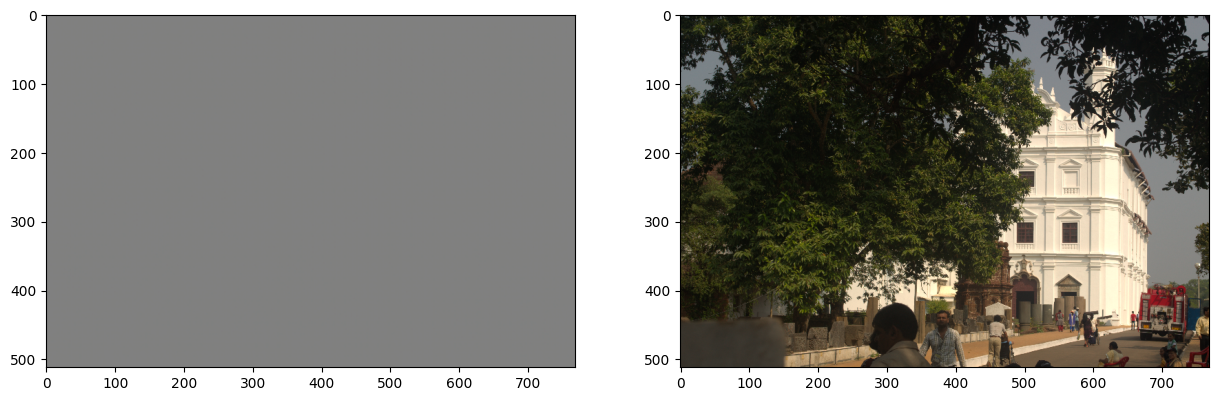

In [4]:

from matplotlib import pyplot as plt
imgs = generateCompressionImages.get_images_without_flips_and_cuts()
a=0
b=0
for img in imgs:
    if a < 5:
        a += 1
        continue
    a, b = img
    a = model(torch.unsqueeze(a,0))
    break
a = torch.squeeze(a)
a = a.permute(1,2,0)
a = torch.add(torch.multiply(a,128), 128)
a = a.detach().cpu().numpy()
np.clip(a, a_min=0, a_max=255, out=a)
a = np.rint(a)
a = a.astype(np.uint8)


b = b.permute(1,2,0)
b = torch.add(torch.multiply(b,128), 128)
b = b.detach().cpu().numpy()
np.clip(b, a_min=0, a_max=255, out=b)
b = np.rint(b)
b = b.astype(np.uint8)
f, ax = plt.subplots(1,2,figsize=(15, 30))
ax[0].imshow(a)
ax[1].imshow(b)
plt.show()

In [1]:
import shutil
import torch
import torch.nn as nn
import numpy as np
torch.manual_seed(100)
np.random.seed(100)
import compress_entropy
import generateCompressionImages

global counter 
counter = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def save_ckp(state, is_best, checkpoint_dir="./entropy_models/rest/", best_model_dir="./entropy_models/best/"):
    global counter 
    f_path = checkpoint_dir + str(counter) + '_checkpoint.pt'
    counter = counter + 1
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_dir + 'best_model.pt'
        shutil.copyfile(f_path, best_fpath)


In [2]:
from torch.cuda.amp import autocast
loss_fn = nn.L1Loss(reduction='mean')  
startup = True
min_lr = 0.003
max_lr = 0.008
decay = 0.95
steps = 200  # might want to bump this up if the HPC is much faster than my computer
falling = True
start_epoch = 0
start_index = 0
momentum = 0.94
step_size = (max_lr-min_lr)/steps

printing = True
epochs = 100
batch_size = 6

model = compress_entropy.Compress(seperable=False, slim=False).to(device).to(memory_format=torch.channels_last)
optimizer = torch.optim.SGD(model.parameters(), lr=max_lr, momentum=momentum)


torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.autograd.set_detect_anomaly(False, check_nan=False)
torch.autograd.profiler.profile(enabled=False)
torch.autograd.profiler.emit_nvtx(enabled=False)
torch.backends.cudnn.benchmark = True
torch.set_grad_enabled(True)

In [3]:
from torch.cuda.amp import autocast
loss_fn = nn.L1Loss(reduction='mean')  
torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.autograd.set_detect_anomaly(False, check_nan=False)
torch.autograd.profiler.profile(enabled=False)
torch.autograd.profiler.emit_nvtx(enabled=False)
torch.backends.cudnn.benchmark = True
torch.set_grad_enabled(True)

In [4]:
los = [0]*10
torch.set_grad_enabled(True)
for epoch in range(start_epoch, epochs):

    if startup:
        training = generateCompressionImages.MakeIter(start_index=start_index if epoch == start_epoch else 0, startup = True)
        training_loader = torch.utils.data.DataLoader(training, batch_size=4, num_workers=2)
        min_lr *= batch_size**0.5  
        max_lr *= batch_size**0.5
        step_size = (max_lr-min_lr)/steps
        optimizer.param_groups[-1]['lr'] = max_lr
        
    else:
        training = generateCompressionImages.MakeIter(start_index=start_index if epoch == start_epoch else 0, epoch=epoch, startup = False)
        training_loader = torch.utils.data.DataLoader(training, batch_size=batch_size, num_workers=2)


    for index, data in enumerate(training_loader):
        inputs, labels = data
        labels.to(memory_format=torch.channels_last)
        inputs.to(memory_format=torch.channels_last)

        with autocast():
            outputs = model(inputs)            
            loss = loss_fn(outputs, labels)

        loss.backward()
        if startup:
            los[index%10] = loss.item()
             
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        else:
            #los[index%10] = loss.item()  # should be deleted
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            if index % 100 in [i for i in range(90,100)]:
                los[index%10] = loss.item()

        if falling:
            optimizer.param_groups[-1]['lr'] = optimizer.param_groups[-1]['lr'] - step_size
            if optimizer.param_groups[-1]['lr'] < min_lr:
                falling = False
                max_lr *= decay
                min_lr *= decay
                steps /= decay
                step_size = (max_lr-min_lr)/steps
                if printing:
                    print("Saving model !!")
                    print("Min lr")
                    print(min_lr)
                    print("Max lr")
                    print(max_lr)
                checkpoint = {'epoch': epoch, 'index': index, 'min_lr': min_lr, 'max_lr': max_lr, 'steps': steps, 'step_size': step_size, 'falling': falling, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'startup': startup}
                save_ckp(checkpoint, True)
                print("model_nr " + str(counter-1) + " saved")
                
                if startup and sum(los)/10 < 0.20 and max(los) < 0.25:
                    startup = False
                    max_lr /= 4
                    min_lr /= 4
                    steps *= 2
                    step_size = (max_lr-min_lr)/steps
                    falling = True
                    optimizer.param_groups[-1]['lr'] = max_lr
                    print("startup done ! !")
                    break
        else: 
            optimizer.param_groups[-1]['lr'] += step_size
            if optimizer.param_groups[-1]['lr'] > max_lr:
                falling = True

        if (startup and printing and index % 10  == 0):
            print("loss")
            print(los)
            print("lr")
            print(optimizer.param_groups[-1]['lr'])
        elif (not startup and printing and index % 100 == 0):
            print("loss")
            print(los)#loss.item())
            print("lr")
            print(optimizer.param_groups[-1]['lr'])

loss
[0.020716892555356026, 0, 0, 0, 0, 0, 0, 0, 0, 0]
lr
0.019534680698695843
loss
[0.5814249515533447, 0.018827049061655998, 0.5433581471443176, 0.5331613421440125, 0.6400080323219299, 0.583378255367279, 0.49372705817222595, 0.5289897918701172, 0.580437421798706, 0.44514888525009155]
lr
0.018922308263000044
loss
[0.4101104736328125, 0.602920413017273, 0.47037485241889954, 0.4110589325428009, 0.3857763111591339, 0.34340900182724, 0.44936445355415344, 0.5204656720161438, 0.2991737723350525, 0.36786529421806335]
lr
0.018309935827304245
loss
[0.3773156702518463, 0.6153823137283325, 0.44415083527565, 0.3238619267940521, 0.41031917929649353, 0.33222299814224243, 0.5237016081809998, 0.4954783022403717, 0.4467257857322693, 0.464884877204895]
lr
0.017697563391608447
loss
[0.2796753942966461, 0.374062180519104, 0.36735501885414124, 0.29408693313598633, 0.34401339292526245, 0.36555972695350647, 0.33554521203041077, 0.39552149176597595, 0.19606982171535492, 0.4377181828022003]
lr
0.0170851909559